# Folded Klein Bottle

An example of an application of the `circle_bundles` pipeline to a dataset where the fibers of the underlying model are topological circles but not geometric ones, and PCA2 fails produce local circular coordinates which are usable for analysis. We instead use the Dreimac library's topologically-flavored sparse circular coordinate algorithm.

We generate a noisy sampling from a 2-manifold $M$ with the topology of a Klein bottle, defined as follows: let $\gamma:\mathbb{R}\to \mathbb{R}^{4}$ be defined by $\gamma(t) = (\sin (t), \cos(t), \sin(2t),0)$ for all $t\in\mathbb{R}$, and let $F = \gamma(\mathbb{R})\subset\mathbb{R}^{4}$.  Note that $F$ is topologically a circle, but geometrically it is folded. In particular, $F$ is invariant under a reflection in the $x$ and $y$ coordinates. Now, define $R:[0,2\pi]\to SO(4)$ by 

$$R(t) = \left(\begin{array}{cccc}
a & b & 0 & d\\
b & a & 0 & -d\\
0 & 0 & 1 & 0\\
-d & d & 0 & c\\
\end{array}\right)$$

where 

$$\alpha = \frac{t}{2},\hspace{1cm}a = \frac{1 + \cos(\alpha)}{2},\hspace{1cm}b = \frac{1 - \cos(\alpha)}{2}$$

$$c = \cos(\alpha),\hspace{1cm}d =  \frac{\sqrt{2}}{2}\sin(\alpha)$$

Observe in particular that $R(0) = I$, $R(2\pi)$ is the matrix which maps $(x,y,z,w)$ to $(y,x,z,-w)$ and $R(t)$ fixes the $z$ axis for all $t$. Finally, we define $M$ by 

$$M = \{(u,v)\in\mathbb{R}^{2}\times\mathbb{R}^{4}: u = (\cos(\theta),\sin(\theta)), \ v\in R(\theta)F\}$$

with a projection map $\pi:M\to \mathbb{S}^{1}$ onto the first factor. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

First, generate a noisy sampling of the manifold $M$:

In [2]:
from circle_bundles.synthetic.tori_and_kb import sample_foldy_klein_bottle_mixed
n_landmarks = 10000
sigma = 0.05
rng = np.random.default_rng(0)
#data = cb.sample_foldy_klein_bottle(n_landmarks, noise = sigma, rng = rng)[0]
#base_angles = np.arctan2(data[:,1], data[:,0]) % (2* np.pi)  #Compute base projections to S1 = R/(2pi Z)

data = sample_foldy_klein_bottle_mixed(n_landmarks, noise = sigma, rng = rng)[0]

from dreimac import CircularCoords

cc = CircularCoords(data, prime = 3, n_landmarks = 500)
base_angles = cc.get_coordinates()

Compute a persistence diagram from a subsample of the data:

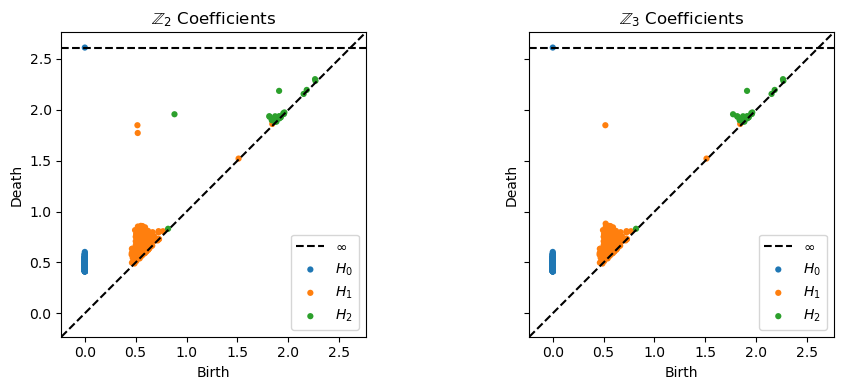

In [3]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title=r"$\mathbb{Z}_{2}$ Coefficients")
plot_diagrams(dgms_3, ax=axes[1], title=r"$\mathbb{Z}_{3}$ Coefficients")


plt.tight_layout()
plt.show()


Optionally run the cell below to view an interactive visualization of the projection map:

In [ ]:
app = cb.show_bundle_vis(data = data, 
                         base_points = base_angles, 
                         base_metric = cb.S1AngleMetric())

Construct a cover of the base space $\mathbb{S}^{1} = \mathbb{R} / (2\pi\mathbb{Z})$ by metric balls around equally-spaced landmarks:

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 10000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

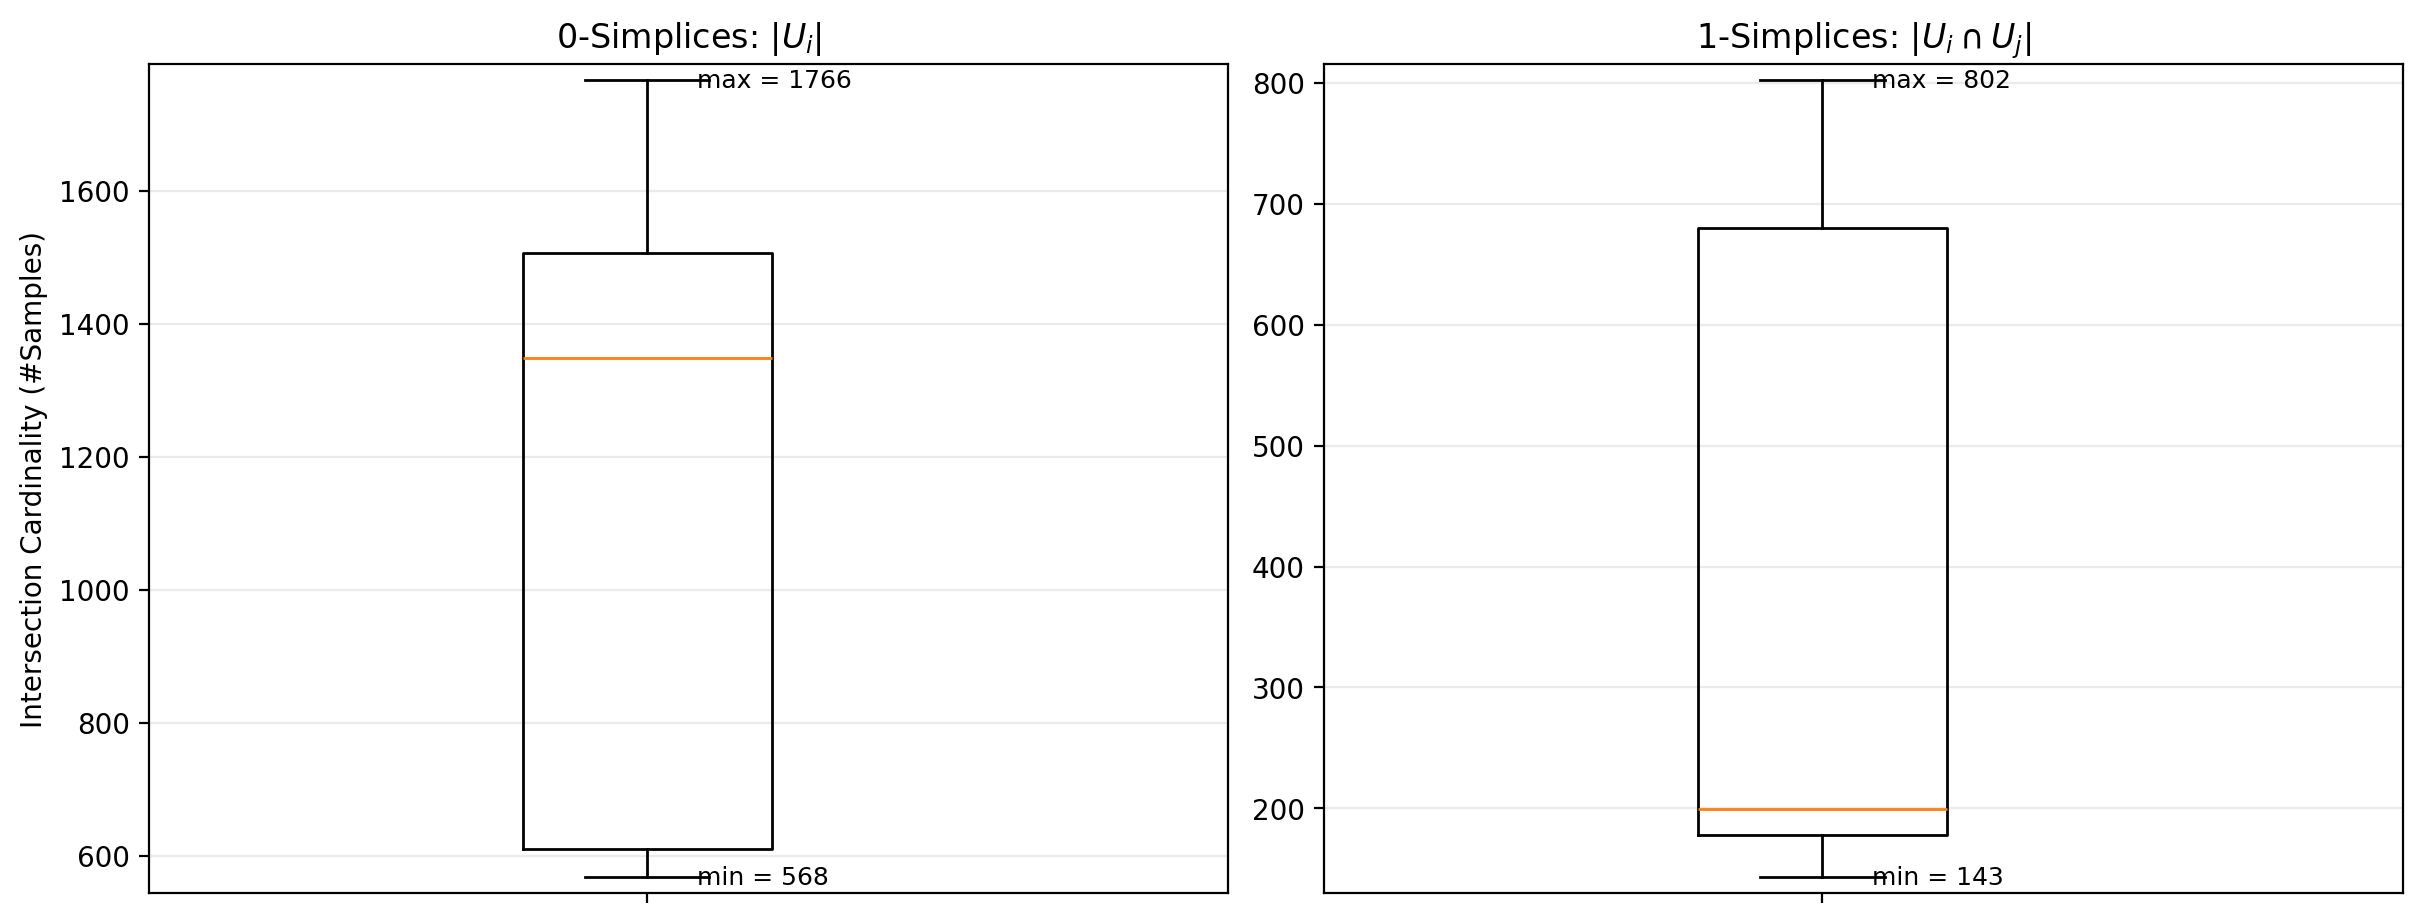

In [66]:
n_landmarks = 12
landmarks = np.linspace(0,2*np.pi,n_landmarks,endpoint = False).reshape(-1,1)
overlap = 1.4
radius = overlap * np.pi / n_landmarks

cover = cb.get_metric_ball_cover(
    base_angles.reshape(-1,1),
    landmarks,
    radius = radius,
    metric = cb.S1AngleMetric())

bundle = cb.Bundle(X = data, cover = cover, show_summary = True)

Show PCA projections of the data in several $\pi^{-1}(U_{j})$:

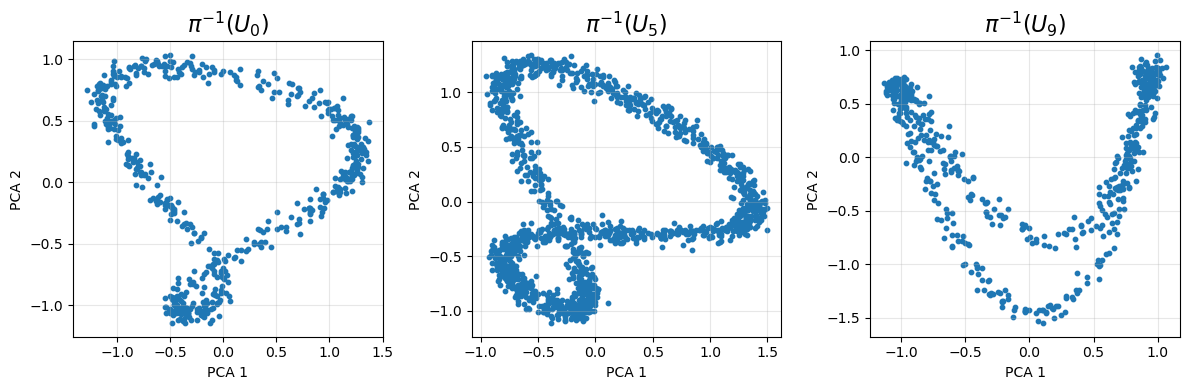

In [71]:
fiber_ids, idx_list, proj_list = cb.get_local_pca(data, cover.U, to_view = [0,5,9])
fig, axes = cb.plot_local_pca(fiber_ids, 
                              proj_list,
                              n_cols = 3, 
                             )
plt.show()

The PCA projections indicate that the fibers are not geometric circles, and PCA2 will fail to produce reasonable local circular coordinates or reliable transition matrices. 

On the other hand, since the fibers look like $\mathbb{S}^{1}$ $\textit{topologically}$, we expect each set $\pi^{-1}(U_{j})$ to produce a prominant 1-dimensional persistent homology class. Compute the persistence diagrams:

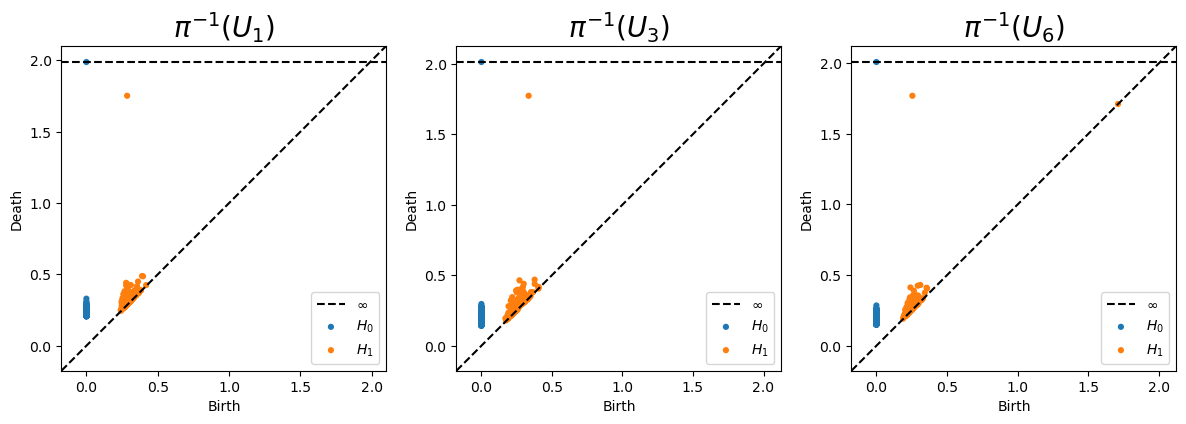

In [68]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [1,3,6], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Use Dreimac to construct a system of local circular coordinate functions:

In [69]:
from dreimac import CircularCoords
cc_alg = cb.DreimacCCConfig(landmarks_per_patch = 200, CircularCoords_cls = CircularCoords)

triv_result = bundle.get_local_trivs(show_summary = True, cc = cc_alg)

<IPython.core.display.Math object>

Show local PCA projections colored according to angles computed with Dreimac:

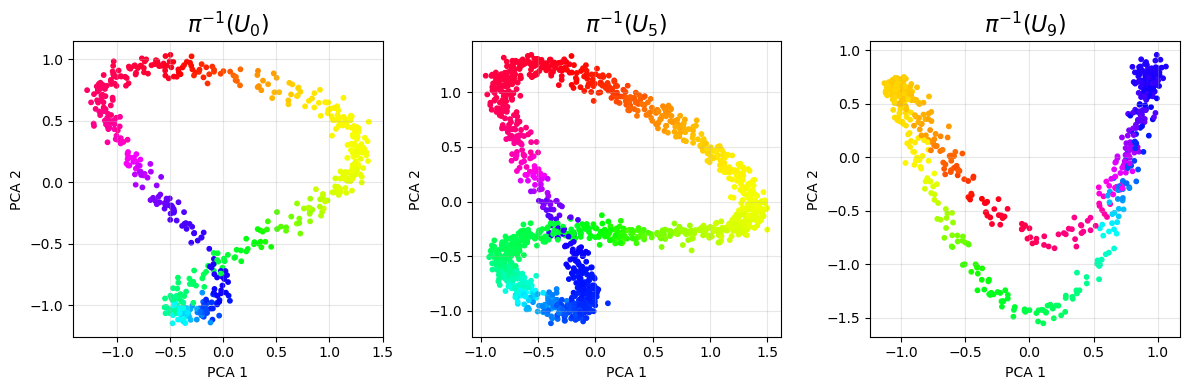

In [70]:
from circle_bundles.analysis.local_analysis import local_pca
to_view = [0,5,9]
fig, axes = local_pca(data, 
                      cover.U,
                      f = triv_result.f,
                      to_view = to_view,
                     )
plt.show()

Now, compute characteristic classes:

In [72]:
class_result = bundle.get_classes(show_summary = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The result above confirm the Klein bottle topology underlying the dataset.  View some correlations between local circular coordinate functions on overlaps:

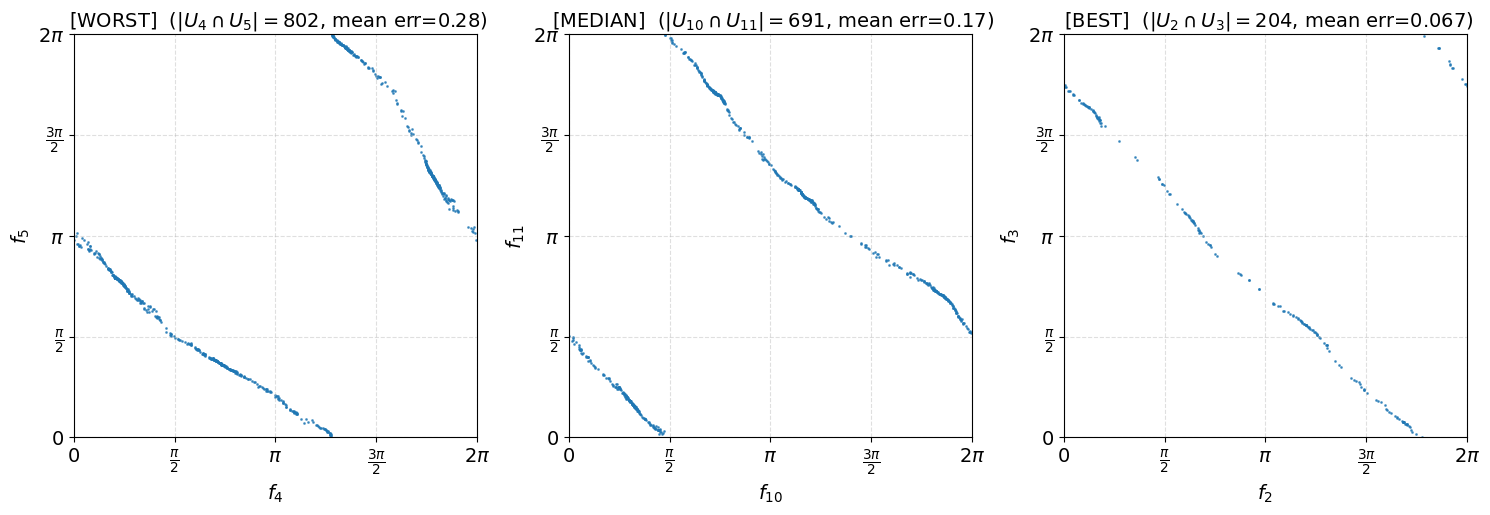

In [73]:
fig = bundle.compare_trivs(max_pairs = 3)

Show a visualization of the nerve of $\mathcal{U}$, with edges labeled by their respective weights. The value of the orientation class representative $\omega$ on each edge is also shown in blue. A potential for $\omega$ after the heaviest edge is removed is shown in red:

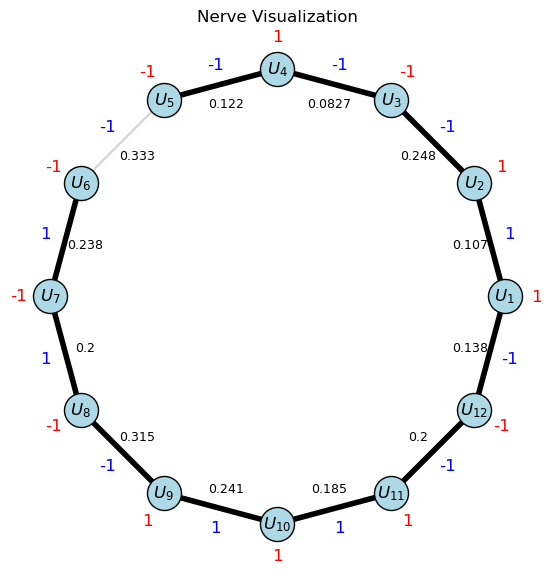

In [74]:
fig = bundle.show_circle_nerve()
plt.show()